<a href="https://colab.research.google.com/github/arthur-sm/BDDI_Nice_Transports/blob/master/BD1_Relatorios_Nice_Transports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conexão com postgres e Relatorios do Sistema

## Instalando bibliotecas de acesso ao postgres, manipulação de dados e gráficos

In [ ]:
#!pip install --user psycopg2-binary
#!pip install --user seaborn
#!pip install --user pandas

### Importando bibliotecas

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

### Usando psycopg2 para configurar conexão

In [3]:
conn = psycopg2.connect(host="motty.db.elephantsql.com", database="ktyofhmr", user="ktyofhmr", password="c9zexS8n52gulCLBY3Bv4d5MXjclNMG7")

# Relatórios

## Relatório 1 - Tempo médio de espera por ônibus em cada Cidade;
### Objetivo: Obter relatório que mostre o tempo médio em minutos que os passageiros aguardam por ônibus nos pontos em cada cidade.
Código para obtenção do resultado:

In [46]:
#Tempo médio de espera de ônibus por cidade (tabelas: chega, deixa, ponto_de_onibus e endereco)
res = pd.read_sql_query("""
    select e.cidade, EXTRACT(EPOCH from (d.datahora_deixa - c.datahora_chegada))/60 as Media_Minutos, c.datahora_chegada, d.datahora_deixa from chega c
    join deixa d on d.fk_cliente_id = c.fk_cliente_id 
    and d.fk_ponto_de_onibus_id = c.fk_ponto_de_onibus_id and to_char(d.datahora_deixa, 'dd-MM-YYYY') = to_char(c.datahora_chegada, 'dd-MM-YYYY') 
    join ponto_de_onibus p on p.id = c.fk_ponto_de_onibus_id
    join endereco e on e.id = p.fk_endereco_id
                        """,conn)
res

,cidade,media_minutos,datahora_chegada,datahora_deixa
0,Vitória,49.734025,2022-11-17 15:00:46,2022-11-17 15:50:30.041508
1,Vitória,40.322343,2022-11-17 15:00:46,2022-11-17 15:41:05.340569
2,Serra,56.844972,2022-11-17 16:15:00,2022-11-17 17:11:50.698318
3,Serra,49.060726,2022-11-17 16:15:00,2022-11-17 17:04:03.643547
4,Cariacica,35.797074,2022-11-15 18:22:00,2022-11-15 18:57:47.824466
5,Cariacica,9.436791,2022-11-15 18:22:00,2022-11-15 18:31:26.207442
6,Vila Velha,44.459618,2022-11-05 19:01:00,2022-11-05 19:45:27.577069
7,Vila Velha,46.083955,2022-11-05 19:01:00,2022-11-05 19:47:05.037291
8,Vitória,48.202756,2022-11-07 19:13:00,2022-11-07 20:01:12.165351
9,Viana,44.933333,2022-11-22 18:55:00,2022-11-22 19:39:56.000000


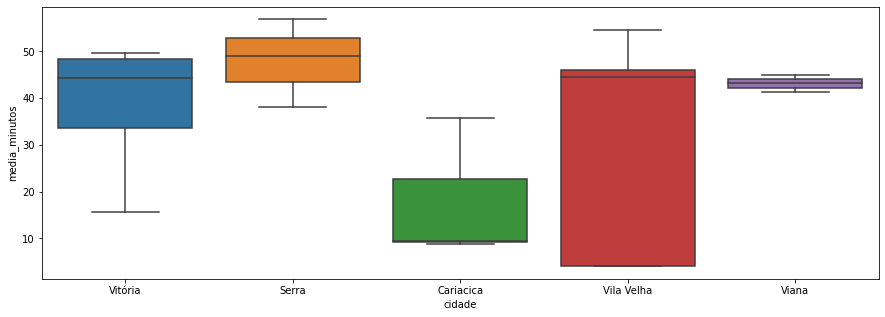

In [8]:
plt.figure(figsize=(15,5))
sns.boxplot(x="cidade",y="media_minutos",data=res)

# ==========================================================================================
## Relatório 2 - Relatório de lotação por horário
### Objetivo: Obter relatório que mostra a evolução da lotação dos ônibus a cada hora.
Código para obtenção do resultado:

In [27]:
res = pd.read_sql_query("""
with data_recebeu as (
select
    to_char(to_timestamp(floor((extract('epoch' from datahora) / 300 )) * 300) 
AT TIME ZONE 'UTC', 'HH24:MI') as horario_recebeu,
    count(datahora) as entradas
from recebe
group by 1
),
data_entregou as (
select
    to_char(to_timestamp(floor((extract('epoch' from e.datahora) / 300 )) * 300) 
AT TIME ZONE 'UTC', 'HH24:MI') as horario_entregou,
    max(to_char(to_timestamp(floor((extract('epoch' from r.datahora) / 300 )) * 300) 
AT TIME ZONE 'UTC', 'HH24:MI')) as max_recebeu,
    count(r.datahora) as saidas
from entrega e
join recebe r on r.fk_cliente_id = e.fk_cliente_id 
and r.fk_onibus_id = e.fk_onibus_id and to_char(e.datahora, 'dd-MM-YYYY') = to_char(r.datahora, 'dd-MM-YYYY')
group by 1
)

select horario_r as Horario,
    CASE WHEN max(Horario_e) is not null 
        THEN 
          CASE WHEN sum(cumulativo_entradas) - sum(cumulativo_saidas) < 0 THEN sum(cumulativo_entradas) ELSE sum(cumulativo_entradas) - sum(cumulativo_saidas) END
        ELSE 
          CASE WHEN sum(cumulativo_entradas) - (LAG(sum(cumulativo_saidas)) over (order by horario_r)) < 0 THEN sum(cumulativo_entradas) ELSE sum(cumulativo_entradas) - (LAG(sum(cumulativo_saidas)) over (order by horario_r)) END
        END as lotacao
 FROM
(
select
  r.horario_recebeu as Horario_r,
  e.horario_entregou as Horario_e,
  sum(r.entradas) over (order by r.horario_recebeu asc rows between unbounded preceding and current row) as cumulativo_entradas,
  sum(e.saidas) over (order by e.horario_entregou asc rows between unbounded preceding and current row) as cumulativo_saidas
from data_recebeu r
left join data_entregou e on e.max_recebeu = r.horario_recebeu
)x
group by Horario_r
order by 1
                            """,conn)
res

,horario,lotacao
0,02:15,NaN
1,06:00,1.0
2,06:40,0.0
3,06:50,1.0
4,07:30,25.0
5,08:10,12.0
6,08:20,12.0
7,08:25,9.0
8,08:50,10.0
9,09:30,7.0


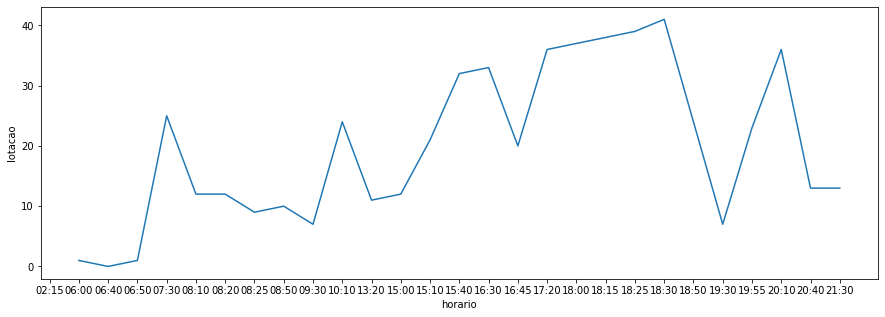

In [25]:
plt.figure(figsize=(15,5))
sns.lineplot(x="horario", y="lotacao", data=res)


# ============================================================
## Relatório 3 - Relatórios sobre linhas mais utilizadas pelos passageiros
### Objetivo: Obter relatorio que mostre as linhas mais utilizadas pelos passageiros;
Código para obtenção do resultado:

In [15]:
res = pd.read_sql_query("""
                  select l.nome, count(r.fk_cliente_id) as passageiros 
                  from linha l
                  join alocado a on a.fk_linha_id = l.id
                  join onibus o on o.id = a.fk_onibus_id
                  join recebe r on r.fk_onibus_id = o.id
                  group by l.nome
                  order by passageiros desc
                  fetch first 5 rows only
                  """,conn)
res

,nome,passageiros
0,CR70,5
1,RD18,4
2,LL13,4
3,JJ90,3
4,GR08,3


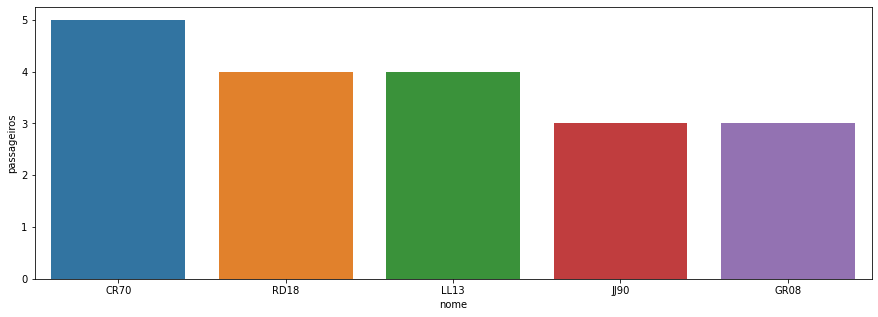

In [16]:
plt.figure(figsize=(15,5))
sns.barplot(x='nome',y='passageiros', data=res)

# ============================================================
## Relatório 4 - Pontos por cidade
### Objetivo: Obter Relatório que mostre a quantidade de endereços/pontos ativos por cada cidade 
Código para obtenção do resultado:

In [42]:
res = pd.read_sql_query("""select e.cidade, count(p.fk_endereco_id) as qtd_endereco from endereco e 
inner join ponto_de_onibus p on (e.id = p.fk_endereco_id)
where p.id in (select fk_ponto_de_onibus_ID from percorre where ativo = True) 
group by cidade; """,conn)
res

,cidade,qtd_endereco
0,Serra,1
1,Vila Velha,2
2,Viana,3
3,Cariacica,4
4,Vitória,2


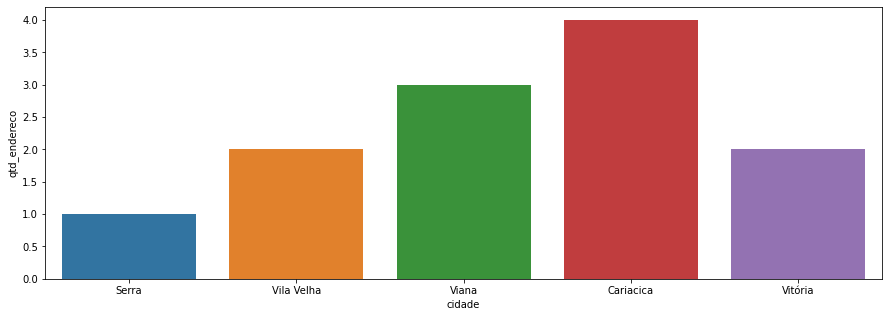

In [44]:
plt.figure(figsize=(15,5))
sns.barplot(x="cidade", y="qtd_endereco", data=res)

# ============================================================
## Relatório 5
### Objetivo: Obter a quantidade de linhas que percorrem cada ponto
Código para obtenção do resultado:

In [32]:
res = pd.read_sql_query("""
                         select pa.id as id_pontos, count(pe.fk_linha_id) as qtd_linhas from passa pa
join ponto_de_onibus p on (pa.fk_ponto_de_onibus_id = p.id)
join percorre pe on (pe.fk_ponto_de_onibus_id = p.id)
where pe.ativo = True
group by pa.id;
                            """,conn)
res

,id_pontos,qtd_linhas
0,22,2
1,10,2
2,35,1
3,13,1
4,2,2
5,18,1
6,27,1
7,30,2
8,3,1
9,34,1


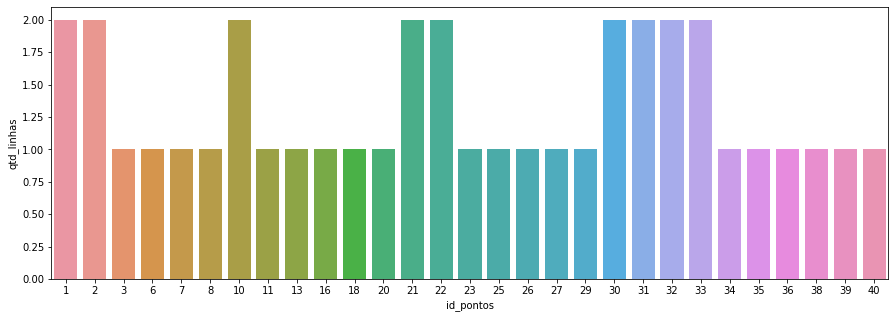

In [33]:
plt.figure(figsize=(15,5))
sns.barplot(x="id_pontos", y="qtd_linhas", data=res)